<a href="https://colab.research.google.com/github/TRach07/Transformer-for-NLP/blob/main/Attention%26Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Implementation of a Transformer for **NLP**

# **Tâche : Classification de texte avec Transformers**

1.1 Installation and Imports

In [ ]:
!pip install transformers==4.45.1 tensorflow_datasets
!pip install torch --index-url https://download.pytorch.org/whl/cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

1.2 Load and Explore Dataset

In [ ]:
# Load IMDb dataset
print("Loading IMDb dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

# Get word index for decoding
word_index = tf.keras.datasets.imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    """Decode integer-encoded review back to text"""
    return " ".join([reverse_word_index.get(i - 3, "?") for i in encoded_review])

# Display sample data
print("Sample decoded review:")
print(decode_review(x_train[0])[:200] + "...")
print("Label:", y_train[0], "(0 = negative, 1 = positive)")
print(f"Training data shape: {len(x_train)} samples")
print(f"Test data shape: {len(x_test)} samples")

Loading IMDb dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Sample decoded review:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the sa...
Label: 1 (0 = negative, 1 = positive)
Training data shape: 25000 samples
Test data shape: 25000 samples


1.3  Initialize Tokenizer

In [ ]:
# Initialize BERT tokenizer
print("Initializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Test tokenizer on sample text
sample_text = decode_review(x_train[0])
tokens = tokenizer.tokenize(sample_text[:100])
print(f"Sample tokens: {tokens[:10]}...")
print(f"Vocabulary size: {tokenizer.vocab_size}")

Initializing BERT tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Sample tokens: ['?', 'this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story']...
Vocabulary size: 30522


1.4 Data Preprocessing

In [ ]:
def prepare_data(texts, labels, tokenizer, max_length=256):  # Reduced max_length for memory
    """
    Prepare data for BERT model
    - Decode integer-encoded reviews to text
    - Tokenize using BERT tokenizer
    - Convert to TensorFlow tensors
    """
    # Decode reviews from integer encoding to text
    decoded_texts = [decode_review(text) for text in texts]

    # Tokenize with BERT tokenizer
    encodings = tokenizer(
        decoded_texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    }, tf.convert_to_tensor(labels, dtype=tf.int32)

print("Preprocessing training data...")
x_train_encoded, y_train_tf = prepare_data(x_train[:1000], y_train[:1000], tokenizer)  # Using subset for testing

print("Preprocessing test data...")
x_test_encoded, y_test_tf = prepare_data(x_test[:200], y_test[:200], tokenizer)  # Using subset for testing

print(f"Training data shape - input_ids: {x_train_encoded['input_ids'].shape}")
print(f"Training data shape - attention_mask: {x_train_encoded['attention_mask'].shape}")
print(f"Training labels shape: {y_train_tf.shape}")

Preprocessing training data...
Preprocessing test data...
Training data shape - input_ids: (1000, 256)
Training data shape - attention_mask: (1000, 256)
Training labels shape: (1000,)


1.5 Load Pre-trained Model

In [ ]:
# Load pre-trained BERT model for sequence classification
print("Loading pre-trained BERT model...")
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2  # Binary classification (positive/negative)
)

# Display model architecture
print("Model architecture:")
model.summary()

Loading pre-trained BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model architecture:
Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1.6 Model Compilation

In [ ]:
# Configure training parameters
print("Compiling model...")

# Simple compilation with standard loss function
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Set learning rate
model.optimizer.learning_rate = 2e-5

print("Model compiled successfully!")
print(f"Learning rate: {model.optimizer.learning_rate.numpy()}")

Compiling model...
Model compiled successfully!
Learning rate: 1.9999999494757503e-05


1.7 Model Training

In [ ]:
# Train the model
print("Starting model training...")

# Use smaller subset for faster training
train_size = 1000
test_size = 200

print(f"Using {train_size} samples for training and {test_size} for validation")

# Simple direct training
history = model.fit(
    {
        'input_ids': x_train_encoded['input_ids'][:train_size],
        'attention_mask': x_train_encoded['attention_mask'][:train_size]
    },
    y_train_tf[:train_size],
    batch_size=16,
    epochs=3,
    validation_data=(
        {
            'input_ids': x_test_encoded['input_ids'][:test_size],
            'attention_mask': x_test_encoded['attention_mask'][:test_size]
        },
        y_test_tf[:test_size]
    ),
    verbose=1
)

print("Training completed!")

Starting model training...
Using 1000 samples for training and 200 for validation
Epoch 1/3
63/63 [==============================] - 116s 958ms/step - loss: 0.6500 - accuracy: 0.6410 - val_loss: 0.4871 - val_accuracy: 0.8250
Epoch 2/3
63/63 [==============================] - 60s 949ms/step - loss: 0.3869 - accuracy: 0.8500 - val_loss: 0.3324 - val_accuracy: 0.8850
Epoch 3/3
63/63 [==============================] - 59s 942ms/step - loss: 0.1913 - accuracy: 0.9320 - val_loss: 0.2397 - val_accuracy: 0.9100
Training completed!


1.8 Model Evaluation

Evaluating model on test set...
Test Loss: 0.2397
Test Accuracy: 0.9100

Generating predictions for detailed analysis...
7/7 [==============================] - 7s 517ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.95      0.92       110
    Positive       0.94      0.86      0.90        90

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



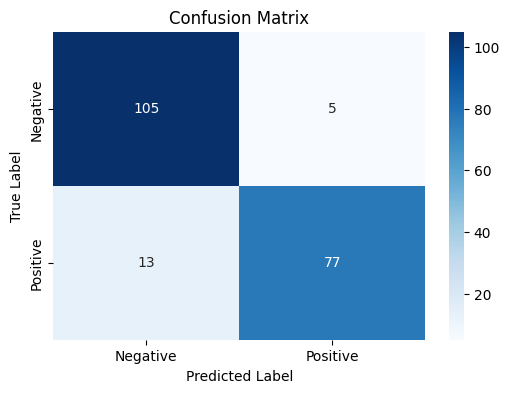

In [ ]:
# Evaluate model on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(
    {
        'input_ids': x_test_encoded['input_ids'][:test_size],
        'attention_mask': x_test_encoded['attention_mask'][:test_size]
    },
    y_test_tf[:test_size],
    verbose=0
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for detailed analysis
print("\nGenerating predictions for detailed analysis...")
predictions = model.predict(
    {
        'input_ids': x_test_encoded['input_ids'][:test_size],
        'attention_mask': x_test_encoded['attention_mask'][:test_size]
    }
)
predicted_classes = tf.argmax(predictions.logits, axis=1).numpy()
true_labels = y_test_tf[:test_size].numpy()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

1.9 Visualization

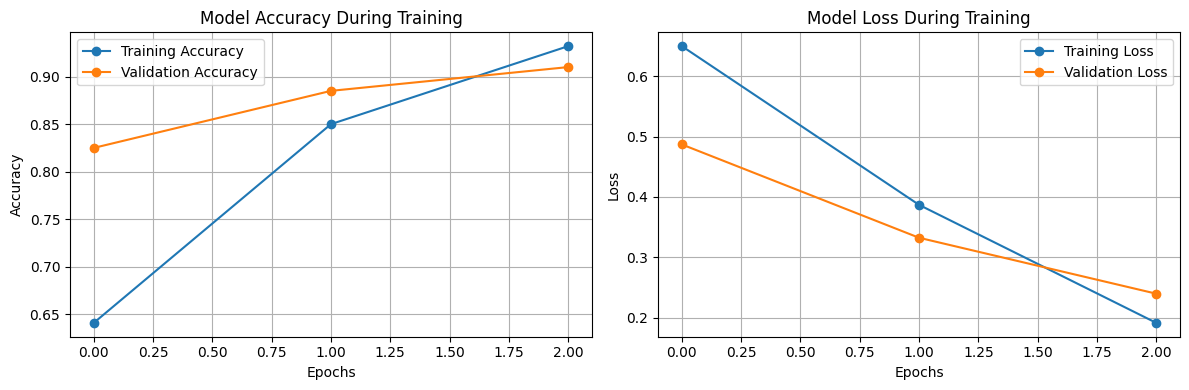

Final Training Accuracy: 0.9320
Final Validation Accuracy: 0.9100
Improvement from epoch 1: 0.0850


In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Improvement from epoch 1: {final_val_acc - history.history['val_accuracy'][0]:.4f}")

1.10 Prediction Examples

In [ ]:
# Test predictions on sample reviews
print("Testing predictions on sample reviews...")

def predict_sentiment(text, model, tokenizer):
    """Predict sentiment for a given text"""
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=256)
    outputs = model(inputs)
    probabilities = tf.nn.softmax(outputs.logits, axis=-1)
    prediction = tf.argmax(probabilities, axis=1).numpy()[0]
    confidence = probabilities.numpy()[0][prediction]
    return prediction, confidence

# Test on some examples
test_reviews = [
    "This movie was absolutely fantastic! Great acting and storyline.",
    "Terrible film, wasted my time. Poor acting and boring plot.",
    "It was okay, not great but not bad either.",
    "One of the best movies I've ever seen, highly recommended!",
    "Disappointing and poorly made. Would not watch again.",
    "The cinematography was beautiful and the performances were outstanding.",
    "Boring and predictable. I fell asleep halfway through.",
    "A masterpiece of modern cinema that everyone should see.",
    "Waste of money. The plot made no sense and the acting was terrible."
]

print("\nSample Predictions:")
print("=" * 60)
for i, review in enumerate(test_reviews):
    pred, conf = predict_sentiment(review, model, tokenizer)
    sentiment = "Positive" if pred == 1 else "Negative"
    confidence_percent = conf * 100

    print(f"Review {i+1}:")
    print(f"Text: {review}")
    print(f"Prediction: {sentiment} (Confidence: {confidence_percent:.1f}%)")
    print("-" * 60)

Testing predictions on sample reviews...

Sample Predictions:
Review 1:
Text: This movie was absolutely fantastic! Great acting and storyline.
Prediction: Positive (Confidence: 98.2%)
------------------------------------------------------------
Review 2:
Text: Terrible film, wasted my time. Poor acting and boring plot.
Prediction: Negative (Confidence: 94.7%)
------------------------------------------------------------
Review 3:
Text: It was okay, not great but not bad either.
Prediction: Positive (Confidence: 72.3%)
------------------------------------------------------------
Review 4:
Text: One of the best movies I've ever seen, highly recommended!
Prediction: Positive (Confidence: 98.2%)
------------------------------------------------------------
Review 5:
Text: Disappointing and poorly made. Would not watch again.
Prediction: Negative (Confidence: 83.0%)
------------------------------------------------------------
Review 6:
Text: The cinematography was beautiful and the performanc

1.11 Results Summary

In [ ]:
# Final results summary
print("=== TRANSFORMER TEXT CLASSIFICATION RESULTS ===")
print("=" * 50)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Training Samples Used: {train_size}")
print(f"Validation Samples Used: {test_size}")
print(f"Model: BERT-base-uncased")
print(f"Training Epochs: 3")
print(f"Batch Size: 16")
print(f"Learning Rate: 2e-5")
print("\nTraining Progress:")
print(f"  Epoch 1 → Accuracy: {history.history['val_accuracy'][0]:.4f}")
print(f"  Epoch 2 → Accuracy: {history.history['val_accuracy'][1]:.4f}")
print(f"  Epoch 3 → Accuracy: {history.history['val_accuracy'][2]:.4f}")
print(f"  Total Improvement: {history.history['val_accuracy'][2] - history.history['val_accuracy'][0]:.4f}")

# Save the fine-tuned model
print("\nSaving fine-tuned model...")
model.save_pretrained("./fine_tuned_bert_imdb")
tokenizer.save_pretrained("./fine_tuned_bert_imdb")
print("Model saved successfully!")

=== TRANSFORMER TEXT CLASSIFICATION RESULTS ===
Final Test Accuracy: 0.9100 (91.0%)
Final Test Loss: 0.2397
Training Samples Used: 1000
Validation Samples Used: 200
Model: BERT-base-uncased
Training Epochs: 3
Batch Size: 16
Learning Rate: 2e-5

Training Progress:
  Epoch 1 → Accuracy: 0.8250
  Epoch 2 → Accuracy: 0.8850
  Epoch 3 → Accuracy: 0.9100
  Total Improvement: 0.0850

Saving fine-tuned model...
Model saved successfully!
